In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

In [2]:
df = pd.read_csv('data/christinaaguilera.csv')
df = df.drop(df[df.release_date == 'None'].index, axis=0)
df = df.reset_index().drop('index', axis=1)
df

,api_path,primary_artist,title,url,song_endpoint,album,release_date,lyrics
0,/songs/3591041,Christina Aguilera,Accelerate,https://genius.com/Christina-aguilera-accelera...,http://api.genius.com/songs/3591041,Liberation,2018-05-03,"Hide it 'til we feel it, then we feel it, 'ti..."
1,/songs/204744,Christina Aguilera,Ain't No Other Man,https://genius.com/Christina-aguilera-aint-no-...,http://api.genius.com/songs/204744,Back to Basics,2006-06-06,"Heeeeey! Yeah (Do your thang, honey!) I cou..."
2,/songs/204971,Christina Aguilera,All I Need,https://genius.com/Christina-aguilera-all-i-ne...,http://api.genius.com/songs/204971,Bionic,2010-06-04,"Kissing your lips, kissing you top to toe Wis..."
3,/songs/783764,Christina Aguilera,Alright Now,https://genius.com/Christina-aguilera-alright-...,http://api.genius.com/songs/783764,None,2018-01-01,"There she stood in the street, smiling from he..."
4,/songs/3233187,Christina Aguilera,America,https://genius.com/Christina-aguilera-america-...,http://api.genius.com/songs/3233187,Served Like a Girl (Music from and Inspired by...,2017-11-03,People come and go through these hotel rooms ...
5,/songs/204662,Christina Aguilera,Angels We Have Heard on High,https://genius.com/Christina-aguilera-angels-w...,http://api.genius.com/songs/204662,My Kind of Christmas,2000-10-24,"Glo-glo-glo-glo-ria Yeah, ooh, oh, ooh oh, ye..."
6,/songs/1872506,Christina Aguilera,Anywhere But Here,https://genius.com/Christina-aguilera-anywhere...,http://api.genius.com/songs/1872506,Finding Neverland: The Album (Songs from the B...,2015-05-04,There's no need for distance No need for touc...
7,/songs/205025,Christina Aguilera,Army of Me,https://genius.com/Christina-aguilera-army-of-...,http://api.genius.com/songs/205025,Lotus,2012-11-09,"I've been standing where you left me, left me..."
8,/songs/205065,Christina Aguilera,Around the World,https://genius.com/Christina-aguilera-around-t...,http://api.genius.com/songs/205065,Lotus,2012-11-09,"Oh, oh, oh, oh Oh, oh, oh, oh Oh, oh, oh, oh ..."
9,/songs/205110,Christina Aguilera,At Last,https://genius.com/Christina-aguilera-at-last-...,http://api.genius.com/songs/205110,None,1999-12-14,At last My love has come along My lonely days...


In [3]:
df.shape

(180, 8)

In [4]:
df.isna().sum()

api_path          0
primary_artist    0
title             0
url               0
song_endpoint     0
album             0
release_date      0
lyrics            0
dtype: int64

In [5]:
lexicon = pd.read_csv('sentiment_lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delim_whitespace=True, header=None)
lexicon.head()

,0,1,2
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [6]:
rs_lexicon = lexicon.pivot(index=0, columns=1, values=2)
rs_lexicon.drop(rs_lexicon.index[0], axis=0, inplace=True)
rs_lexicon.head()

1,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [7]:
for col in rs_lexicon.columns:
    print(f'{col}: {rs_lexicon[col].sum()}')

anger: 1247
anticipation: 839
disgust: 1058
fear: 1476
joy: 689
negative: 3324
positive: 2312
sadness: 1191
surprise: 534
trust: 1231


In [ ]:
vocabulary = list(rs_lexicon.index)
emotions = {}
for word in vocabulary:
    rs_lex_filtered = rs_lexicon.loc[[word]]
    values = [col for col in rs_lex_filtered.columns if int(rs_lex_filtered[col].values) == 1]
    if values != []:
        emotions[word] = values

In [ ]:
emotions

In [ ]:
corpus = []
tokenizer = RegexpTokenizer(r'\w\w+') 
lemmatizer = WordNetLemmatizer()
for lyric in df['lyrics']:
    token = tokenizer.tokenize(str(lyric).lower())
    lemmatized_token = []
    for word in token:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_token.append(lemmatized_word)
    corpus.append(lemmatized_token)

In [ ]:
song_emotions = []
for song in corpus:
    emotion_count = {'anger': 0, 
                     'positive': 0,
                     'negative': 0,
                     'anticipation': 0, 
                     'disgust': 0,
                     'fear': 0, 
                     'joy': 0, 
                     'sadness': 0, 
                     'surprise': 0, 
                     'trust': 0} 
    for word in song:
        if word in emotions.keys():
            word_emotions = emotions[word]
            for emotion in word_emotions:
                emotion_count[emotion] += 1
    song_emotions.append(emotion_count)

In [ ]:
len(song_emotions)

In [ ]:
song_emotions

In [ ]:
df = df.join(pd.DataFrame(song_emotions), how='left')

In [15]:
df.isna().sum()

api_path          0
primary_artist    0
title             0
url               0
song_endpoint     0
album             0
release_date      0
lyrics            0
anger             0
anticipation      0
disgust           0
fear              0
joy               0
negative          0
positive          0
sadness           0
surprise          0
trust             0
dtype: int64

# 1. Sentiment analysis over time

In [16]:
df_normalized = df.groupby('release_date')[['anger', 'positive', 'negative', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']].sum()

df_normalized.head()
for col in df_normalized.columns:
    df_normalized[col] = df_normalized[col].apply(int)

In [17]:
sums = df_normalized['anger'] + df_normalized['positive'] + df_normalized['negative'] + df_normalized['anticipation'] + df_normalized['disgust'] + df_normalized['fear'] + df_normalized['joy'] + df_normalized['sadness'] + df_normalized['surprise'] + df_normalized['trust']   
df_normalized['sum'] = sums
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-06-15,0,2,9,2,2,3,0,1,0,8,27
1999-02-02,0,13,10,17,0,4,6,3,3,8,64
1999-06-22,1,45,1,6,1,1,38,2,2,12,109
1999-08-09,1,68,3,36,0,1,34,0,26,51,220
1999-08-24,22,173,45,66,21,26,110,36,31,106,636


In [18]:
df_normalized.index = pd.to_datetime(df_normalized.index)
df_normalized = df_normalized.resample('Y').sum()
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-12-31,0,2,9,2,2,3,0,1,0,8,27
1999-12-31,25,356,62,146,23,39,224,43,76,201,1195
2000-12-31,62,309,91,177,48,64,239,63,61,137,1251
2001-12-31,12,128,34,55,6,15,94,22,18,69,453
2002-12-31,127,318,271,191,92,155,166,141,87,198,1746


In [19]:
cols = list(df_normalized.columns)
zeros = (df_normalized.anger == 0) & (df_normalized.positive == 0) & (df_normalized.negative == 0) & (df_normalized.anticipation == 0) & (df_normalized.disgust == 0) & (df_normalized.fear == 0) & (df_normalized.joy == 0) & (df_normalized.sadness == 0) & (df_normalized.surprise == 0) & (df_normalized.trust == 0) 
df_normalized.drop(df_normalized[zeros].index, axis=0, inplace=True)
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1998-12-31,0,2,9,2,2,3,0,1,0,8,27
1999-12-31,25,356,62,146,23,39,224,43,76,201,1195
2000-12-31,62,309,91,177,48,64,239,63,61,137,1251
2001-12-31,12,128,34,55,6,15,94,22,18,69,453
2002-12-31,127,318,271,191,92,155,166,141,87,198,1746
2003-12-31,13,94,32,35,8,16,46,22,20,64,350
2004-12-31,7,23,23,15,5,7,11,8,8,15,122
2006-12-31,73,375,169,191,76,117,234,105,103,265,1708
2007-12-31,19,75,51,26,9,16,51,33,8,36,324


/Users/dunyaoguz/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


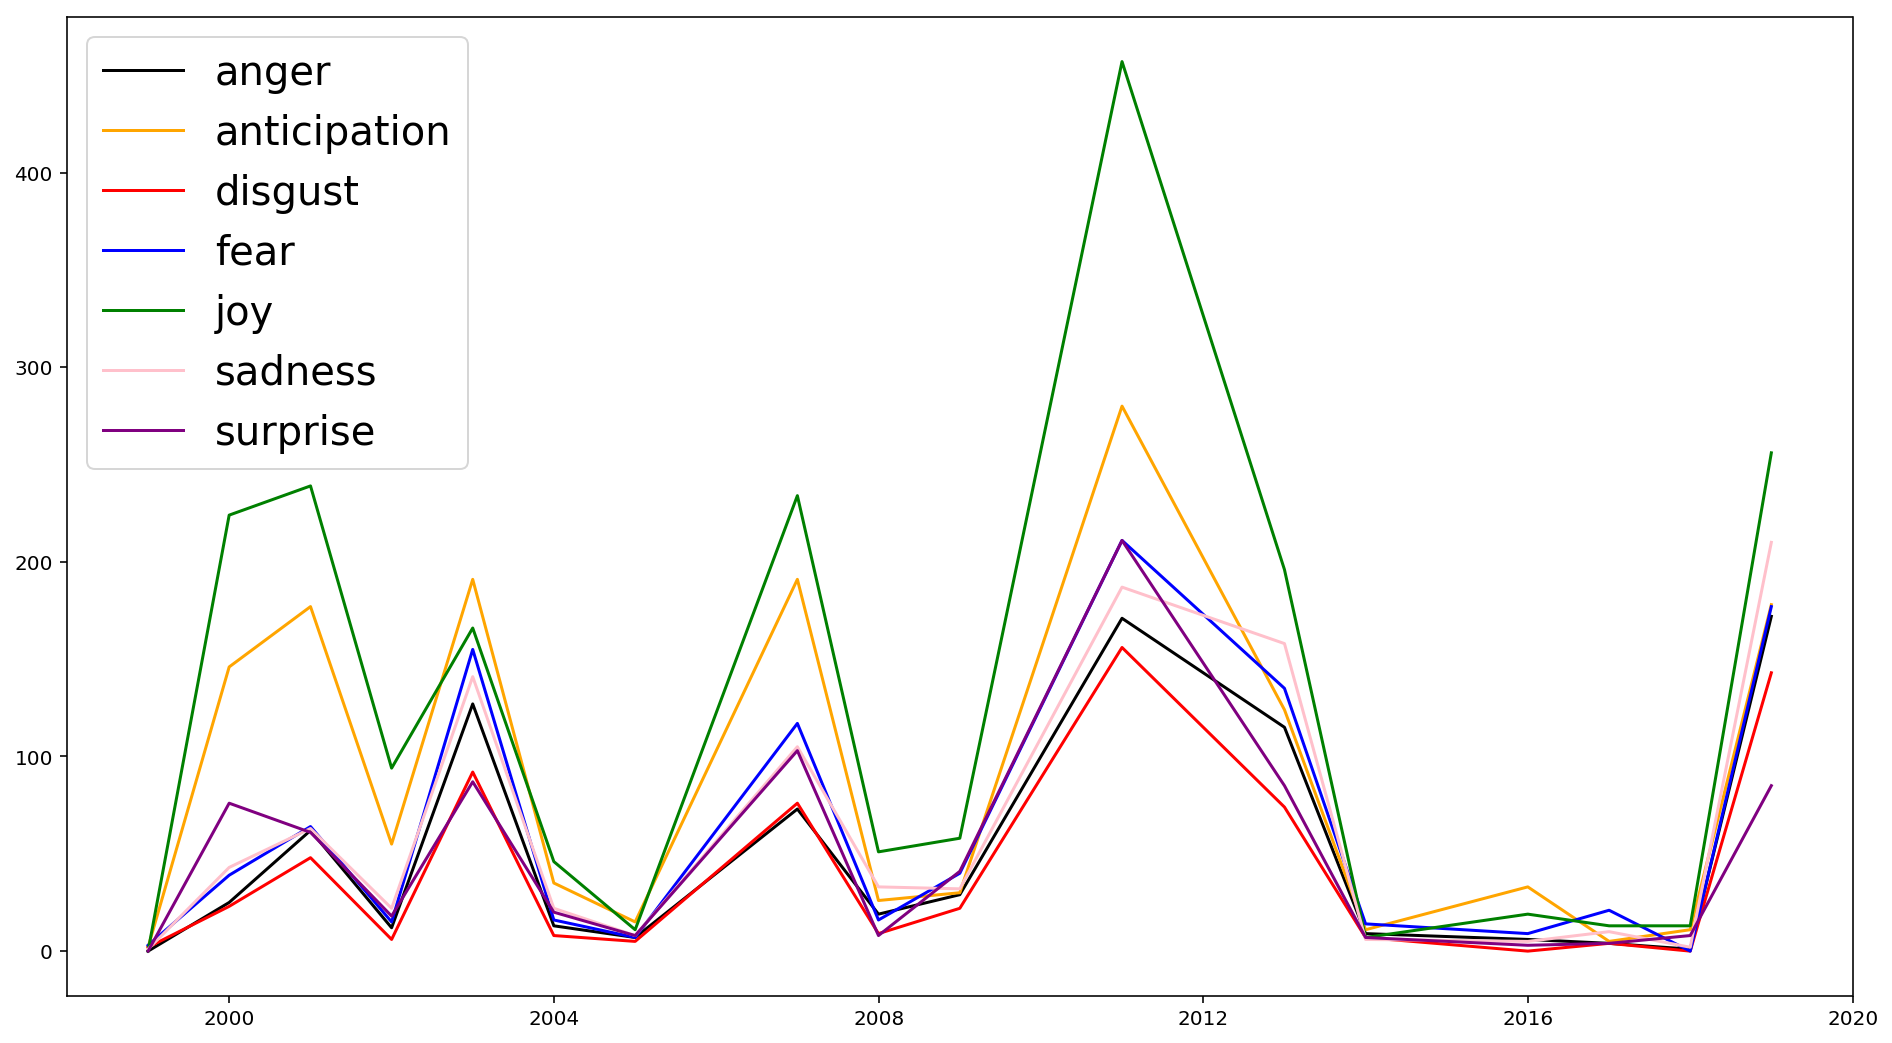

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='purple');
plt.legend(fontsize=20);

In [21]:
cols.remove('sum')
for col in cols:
    df_normalized[col] = df_normalized[col] / df_normalized['sum']

In [22]:
df_normalized = df_normalized.reset_index()

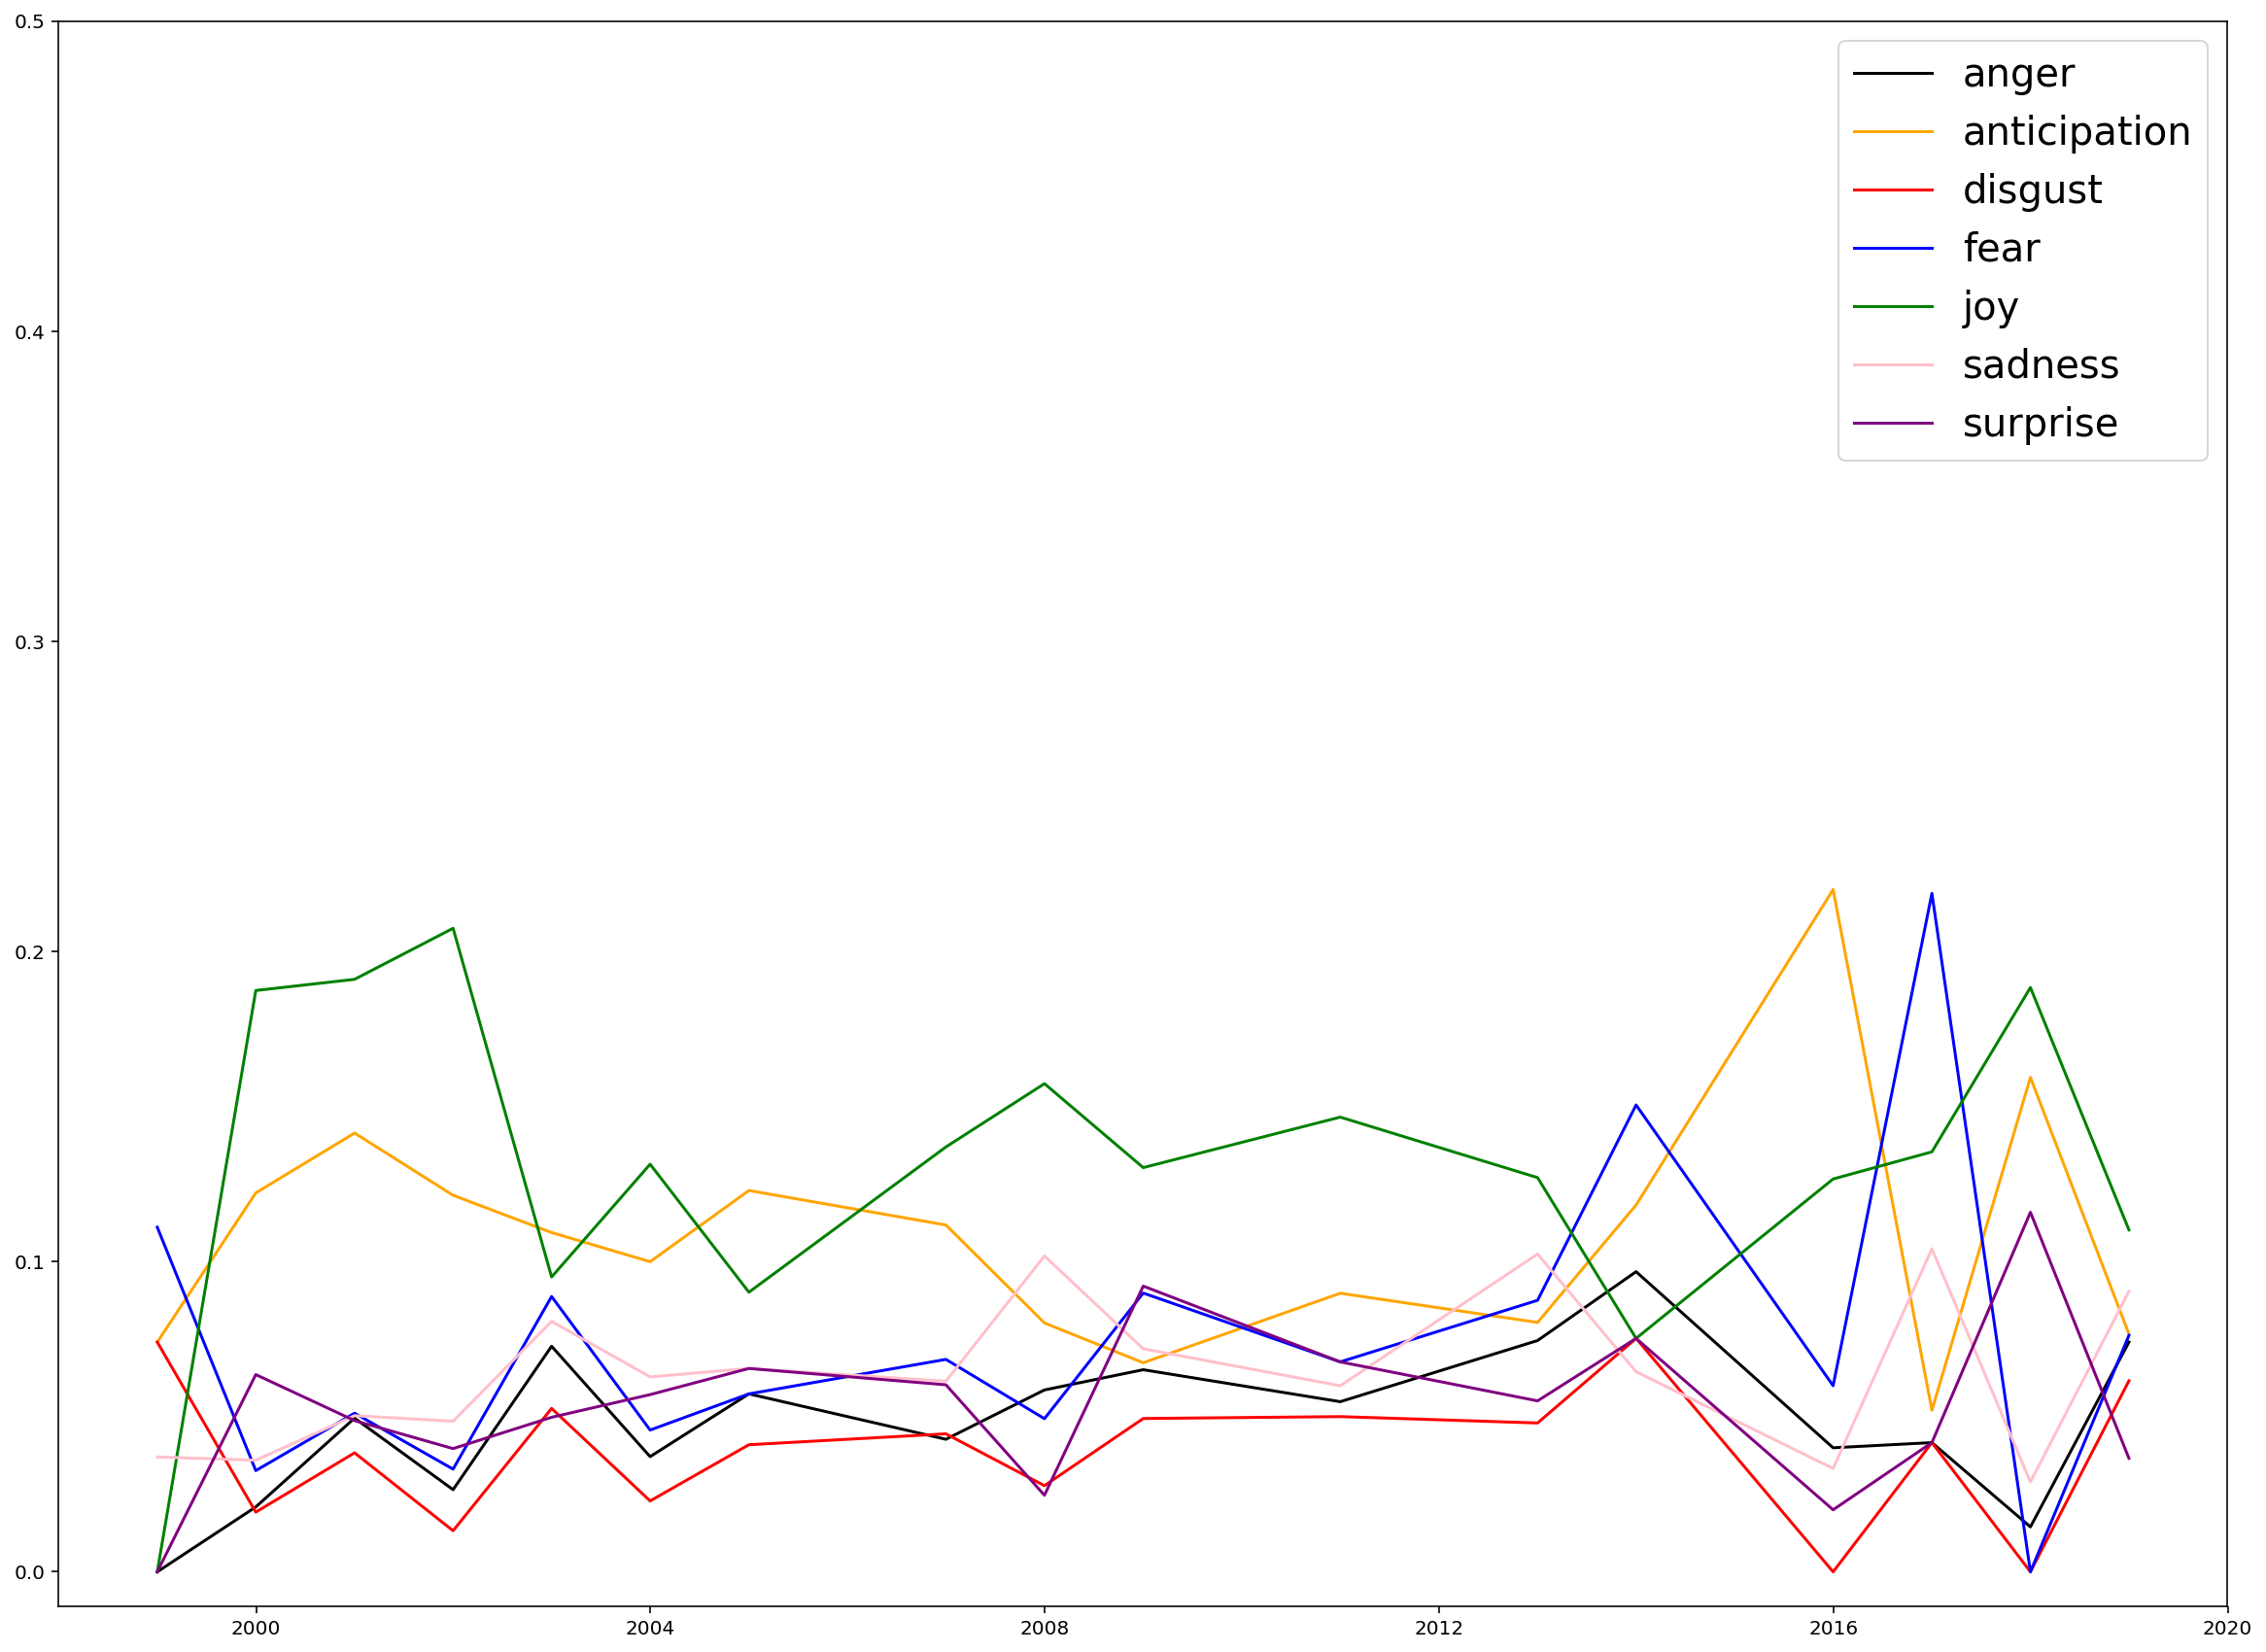

In [23]:
plt.figure(figsize=(20, 15))
plt.plot(df_normalized.release_date, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.release_date, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.release_date, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.release_date, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.release_date, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.release_date, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.release_date, df_normalized.surprise, label='surprise', c='purple');
plt.ylim(top=0.5)
plt.legend(fontsize=20);

In [24]:
df_normalized['release_year'] = df_normalized['release_date'].dt.year

In [87]:
from bokeh.plotting import figure, output_file, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, Legend
output_notebook()

a = int(df_normalized['release_year'].min())
b = int(df_normalized['release_year'].max())

p = figure(plot_width=900, plot_height=500, x_range=(a, b), y_range=(0, 0.5), 
           tools='pan,box_zoom,reset,save', x_axis_label='Years', y_axis_label='Percent of sentiment expressed',
           toolbar_location='above')

p.line(df_normalized['release_year'], df_normalized['anger'], legend='anger', line_dash="4 4", color='deepskyblue')
p.circle(df_normalized['release_year'], df_normalized['anger'], legend='anger', size=8, color='deepskyblue')

p.line(df_normalized['release_year'], df_normalized['disgust'], legend='disgust', color='red', line_dash="4 4")
p.circle(df_normalized['release_year'], df_normalized['disgust'], legend='disgust', fill_color='red', size=8, color='red')

p.line(df_normalized['release_year'], df_normalized['fear'], legend='fear', color='orange', line_dash="4 4")
p.circle(df_normalized['release_year'], df_normalized['fear'], legend='fear', fill_color='orange', size=8, color='orange')


p.line(df_normalized['release_year'], df_normalized['anticipation'], legend='anticipation', color='hotpink', line_dash="4 4")
p.circle(df_normalized['release_year'], df_normalized['anticipation'], legend='anticipation', fill_color='hotpink', size=8, color='hotpink')

p.line(df_normalized['release_year'], df_normalized['joy'], legend='joy', color='green', line_dash="4 4")
p.circle(df_normalized['release_year'], df_normalized['joy'], legend='joy', fill_color='green', size=8, color='green')

p.line(df_normalized['release_year'], df_normalized['sadness'], legend='sadness', color='blue', line_dash="4 4")
p.circle(df_normalized['release_year'], df_normalized['sadness'], legend='sadness', fill_color='blue', size=8, color='blue')

p.line(df_normalized['release_year'], df_normalized['surprise'], legend='surprise', color='blueviolet', line_dash="4 4")
p.circle(df_normalized['release_year'], df_normalized['surprise'], legend='surprise', fill_color='blueviolet', size=8, color='blueviolet')

anger = p.circle(df_normalized['release_year'], df_normalized['anger'], size=20,
                fill_color="grey", hover_fill_color="deepskyblue",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

surprise = p.circle(df_normalized['release_year'], df_normalized['surprise'], size=20,
                fill_color="grey", hover_fill_color="blueviolet",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

anticipation = p.circle(df_normalized['release_year'], df_normalized['anticipation'], size=20,
                fill_color="grey", hover_fill_color="hotpink",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

sadness = p.circle(df_normalized['release_year'], df_normalized['sadness'], size=20,
                fill_color="grey", hover_fill_color="blue",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

disgust = p.circle(df_normalized['release_year'], df_normalized['disgust'], size=20,
                fill_color="grey", hover_fill_color="red",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

fear = p.circle(df_normalized['release_year'], df_normalized['fear'], size=20,
                fill_color="grey", hover_fill_color="red",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

joy = p.circle(df_normalized['release_year'], df_normalized['joy'], size=20,
                fill_color="grey", hover_fill_color="green",
                fill_alpha=0.02, hover_alpha=0.2,
                line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[anger, sadness, surprise, fear, anticipation, disgust, joy], mode='vline'))

p.xaxis.major_tick_line_color = 'firebrick'
p.xaxis.major_tick_line_width = 5
p.xaxis.minor_tick_line_color = 'orange'
p.axis.major_tick_out = 10
p.axis.minor_tick_out = 8

show(p)

Loading BokehJS ...

# 2. Clustering songs

https://www.sciencedirect.com/topics/computer-science/cosine-similarity

In [113]:
cluster_df = df[['title', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'surprise', 'trust']]
X = cluster_df.drop(['title'], axis=1)
y = cluster_df['title']

In [114]:
X.head()

,anger,anticipation,disgust,fear,joy,surprise,trust
0,19,17,5,20,16,10,18
1,1,11,4,0,19,3,22
2,1,9,1,4,11,5,11
3,0,3,4,2,29,3,8
4,1,11,0,0,13,8,13


In [115]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [116]:
pca = PCA(n_components=2)
pca = pca.fit_transform(X)

In [117]:
KMeans = KMeans(n_clusters = 4)
KMeans.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [118]:
pca = pd.DataFrame(pca, columns = ['Component1', 'Component2'])

In [119]:
pca['cluster'] = KMeans.labels_

In [120]:
KMeans.cluster_centers_

array([[-10.79221661,   2.82661112],
       [  7.90338613,   3.79284095],
       [ 39.41499696,   5.78296848],
       [  1.68647392, -11.48369948]])

In [121]:
pca.cluster.unique()

array([3, 1, 0, 2])

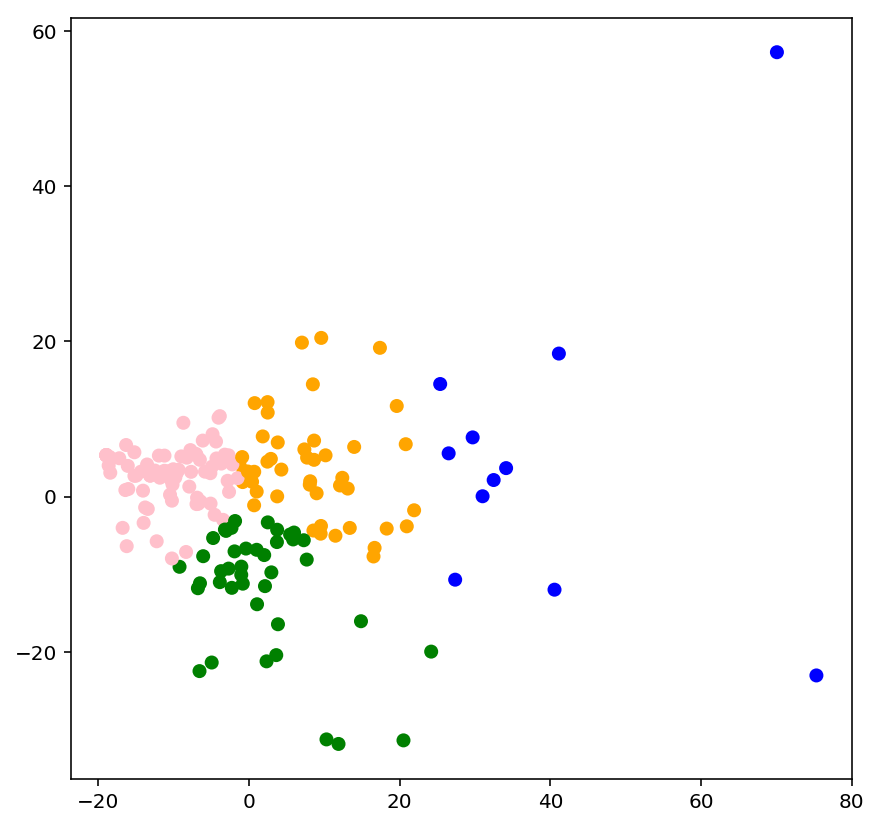

In [123]:
plt.figure(figsize=(7,7))
colors = ['pink', 'orange', 'blue', 'green']
pca['color'] = pca['cluster'].map(lambda x: colors[x])
plt.scatter(pca['Component1'], pca['Component2'], c = pca['color']);

In [150]:
pca.head()

,Component1,Component2,cluster,color,title
0,14.852252,-16.056596,3,#2166ac,Accelerate
1,10.146178,5.328025,1,#4393c3,Ain't No Other Man
2,-0.368814,2.809132,1,#4393c3,All I Need
3,8.462608,14.480658,1,#4393c3,Alright Now
4,2.883947,4.868473,1,#4393c3,America


In [172]:
colors= ["#d1e5f0", "#2166ac", "#21295C", "#f4a582"]

pca['color'] = pca['cluster'].map(lambda x: colors[x])

In [173]:
pca['title'] = df['title']

In [179]:
from bokeh.plotting import figure, output_file, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, Legend
output_notebook()

p = figure(toolbar_location="above", plot_width=900, plot_height=450, tools='pan,box_zoom,reset,save',
           x_axis_label='Principal Component 1', y_axis_label='Principal Component 2')

palette = ["#053061", "#2166ac", "#92c5de", "#d1e5f0",
            "#f7f7f7", "#fddbc7", "#f4a582", "#d6604d", "#b2182b", "#67001f"]

source = ColumnDataSource(pca)
p.circle('Component1', 'Component2', size=10, source=pca, color='color', line_color="black", fill_alpha=0.8)
p.background_fill_color = "#f2f2f2"
p.grid.grid_line_color = "white"
p.add_tools(HoverTool(tooltips=[("Song", "@title")], mode='mouse'))

show(p)

Loading BokehJS ...

# 3. Positivity Score

* greater than 0.05 --> positive
* between -0.05 and 0.05 --> neutral
* less than -0.05 --> negative

In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [45]:
def lyrics_analyzer(lyrics):
    score = analyser.polarity_scores(lyrics)
    return score['compound']

In [46]:
polarity = []
for lyric in df['lyrics']:
    polarity.append(lyrics_analyzer(str(lyric)))

In [47]:
pd.DataFrame(polarity)

,0
0,-0.5435
1,0.9989
2,0.9947
3,0.9849
4,0.9935
5,0.9892
6,-0.8201
7,0.9388
8,0.9981
9,0.9874
